# Jafari Prayer Times 2025

Author: [Hamid Ali Syed](https://syedha.com)

In [1]:
import os
import glob
import pickle
import pandas as pd
import arabic_reshaper
from datetime import datetime
from geopy.geocoders import Nominatim
from datetime import datetime, timedelta
from prayer_times_calculator import PrayerTimesCalculator

In [2]:
def find_city(lat, lon):
    geolocator = Nominatim(user_agent="geo_locator")
    location = geolocator.reverse((lat, lon), language='en')

    # Extract city name
    city = location.raw.get('address', {}).get('city', 'Unknown City')
    state = location.raw.get('address', {}).get('state', '')
    country = location.raw.get('address', {}).get('country', '')
    return city, state, country


# Function to clean and reformat Hijri Date
def reformat_hijri_date(date):
    # Remove extra spaces
    clean_date = " ".join(date.split())
    # Ensure the format is DD-MM-YYYY
    parts = clean_date.split("-")
    if len(parts) == 3:
        day = parts[0].zfill(2)  # Ensure day is 2 digits
        month = parts[1].zfill(2)  # Ensure month is 2 digits
        year = parts[2]  # Keep year as is
        return f"{day}-{month}-{year}"
    return clean_date  # Return unmodified if format is unexpected


# Function to extract month and year from Hijri Date
def extract_group(date):
    # Remove extra spaces and split the date
    clean_date = " ".join(date.split())
    parts = clean_date.split("-")
    if len(parts) == 3:
        month = parts[1].zfill(2)  # Ensure month is two digits
        year = parts[2]  # Extract the year
        return f"{month}-{year}"
    return None  # Return None if the format is unexpected


def add_location_metadata(df, lat, lon):
    """
    Adds latitude, longitude, and city name as attributes to a DataFrame.

    Parameters:
    - df: pd.DataFrame - The DataFrame to add metadata to.
    - lat: float - Latitude of the location.
    - lon: float - Longitude of the location.

    Returns:
    - df: pd.DataFrame with updated attrs containing lat, lon, and city.
    """
    
    city, state, country = find_city(lat=lat, lon=lon)

    # Add metadata
    df.attrs["latitude"] = lat
    df.attrs["longitude"] = lon
    df.attrs["city"] = city
    df.attrs["state"] = state
    df.attrs["country"] = country

    print(f"Added location metadata: {city}, {state}, {country}")
    return df


In [3]:
def generate_prayer_times_calendar(
    lat, long, year, month, output_dir,
    calc_method='jafari', school='shafi',
    midnightMode='jafari', latitudeAdjustmentMethod='one seventh',
    tune=True, imsak_tune=0, fajr_tune=0, sunrise_tune=0, dhuhr_tune=0, 
    asr_tune=0, maghrib_tune=0, sunset_tune=0, isha_tune=0, show=False, save=True
):
    """
    Generate prayer times for a given month and year and save to a file.
    
    Parameters:
        lat (float): Latitude of the location.
        long (float): Longitude of the location.
        year (int): Year for which to generate the calendar.
        month (int): Month for which to generate the calendar.
        output_dir (str): Directory to save the file.
        calc_method (str): Calculation method. Default is 'jafari'.
        school (str): School of thought. Default is 'shafi'.
        midnightMode (str): Midnight mode. Default is 'jafari'.
        latitudeAdjustmentMethod (str): Latitude adjustment method. Default is 'one seventh'.
        tune (bool): Whether to enable tuning of prayer times.
        imsak_tune, fajr_tune, sunrise_tune, dhuhr_tune, asr_tune, maghrib_tune, 
        sunset_tune, isha_tune (int):
            Tuning values for each prayer in minutes. Default is 0 except for maghrib_tune (1).
        show (bool): Whether to display the DataFrame. Default is False.
        save (bool): Whether to save the DataFrame to a file. Default is True.
    
    Returns:
        pd.DataFrame, int: The prayer times DataFrame and the month.
    """
    # Calculate start and end date for the month
    start_date = datetime(year, month, 1)
    next_month = month % 12 + 1
    next_year = year if month < 12 else year + 1
    end_date = datetime(next_year, next_month, 1) - timedelta(days=1)

    # Initialize an empty list to store prayer times
    prayer_times_list = []

    # Iterate over each day in the month
    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime("%Y-%m-%d")
        
        # Fetch prayer times for the current date
        calc = PrayerTimesCalculator(
            latitude=lat,
            longitude=long,
            calculation_method=calc_method,
            date=date_str,
            school=school,
            midnightMode=midnightMode,
            latitudeAdjustmentMethod=latitudeAdjustmentMethod,
            tune=tune,
            imsak_tune=imsak_tune,
            fajr_tune=fajr_tune,
            sunrise_tune=sunrise_tune,
            dhuhr_tune=dhuhr_tune,
            asr_tune=asr_tune,
            maghrib_tune=maghrib_tune,
            sunset_tune=sunset_tune,
            isha_tune=isha_tune,
        )
        
        times = calc.fetch_prayer_times()
        
        # Add the fetched times to the list
        prayer_times_list.append({
            "Gregorian Date": current_date.strftime("%d %B %Y"),
            "Hijri Date": f"{times['date']['hijri']['day']}-\
            {times['date']['hijri']['month']['number']}-{times['date']['hijri']['year']}",
            "Hijri Month": times['date']['hijri']['month']['ar'],
            "Fajr": times['Fajr'],
            "Sunrise": times['Sunrise'],
            "Dhuhr": times['Dhuhr'],
            "Asr": times['Asr'],
            "Sunset": times['Sunset'],
            "Maghrib": times['Maghrib'],
            "Isha": times['Isha'],
        })
        
        # Increment the date
        current_date += timedelta(days=1)

    # Create a DataFrame to organize the data
    df_prayer_times = pd.DataFrame(prayer_times_list)
    df_prayer_times = add_location_metadata(df_prayer_times, lat=lat, lon=long)
    
    # Display the DataFrame if required
    if show:
        display(df_prayer_times)

    # Save the DataFrame
    if save:
        save_prayer_times(
            df_prayer_times, year=year, month=month, output_dir=output_dir, file_format="pickle")
    # Return the DataFrame and the current month
    return df_prayer_times, month

In [4]:
def save_prayer_times(df, year, month, output_dir, file_format="pickle"):
    """
    Save the prayer times DataFrame in the specified format.

    Parameters:
        df (pd.DataFrame): DataFrame containing prayer times.
        year (int): Year of the data.
        month (int): Month of the data.
        output_dir (str): Directory to save the file.
        file_format (str): Format to save the file. Options: "pickle" or "csv". Default is "pickle".

    Returns:
        str: The path of the saved file.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate the file name
    file_name = f"prayer_times_{year}_{month:02d}"
    if file_format == "pickle":
        file_name += ".pkl"
    elif file_format == "csv":
        file_name += ".csv"
    else:
        raise ValueError("Unsupported file format. Use 'pickle' or 'csv'.")

    output_path = os.path.join(output_dir, file_name)

    # Save the DataFrame
    if file_format == "pickle":
        with open(output_path, "wb") as f:
            pickle.dump(df, f)
    elif file_format == "csv":
        df.to_csv(output_path, index=False)

    print(f"Saved prayer times for {year}-{month:02d} in {file_format.upper()} format to: {output_path}")
    return output_path

## Generate Time Tables

In [5]:
# Setup parameters
# Srinagar
latitude = 34.085557
longitude = 74.799499
year_gg = 2025

city, state, country = find_city(lat = latitude, lon = longitude)
dir_name = f"{city}_{state}_{country}".replace(" ", "_")
print(f"{dir_name}")
output_directory = f"/Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/{dir_name}"
os.makedirs(output_directory, exist_ok=True)
# Loop through months and save each month's DataFrame
for month in range(1, 13):
    # Generate the output file path using os.path.join
    output_file = os.path.join(output_directory, f"prayer_times_{year_gg}_{month:02d}.pkl")
    # Check if file exists and skip
    if os.path.exists(output_file):
        print(f"Skipping {month}: already processed.: {output_file}")
        continue

    try:
        # Generate prayer times for the month
        generate_prayer_times_calendar(
            lat=latitude,
            long=longitude,
            year=year_gg,
            month=month,
            output_dir=output_directory,
            show=False,
            save=True,
        )
        print(f"Saved prayer times for month {month} in pickle format")
#         print(f"in {output_file}")

    except Exception as e:
        print(f"Error processing month {month}: {e}")

Srinagar_Jammu_and_Kashmir_India
Skipping 1: already processed.: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/prayer_times_2025_01.pkl
Skipping 2: already processed.: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/prayer_times_2025_02.pkl
Skipping 3: already processed.: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/prayer_times_2025_03.pkl
Skipping 4: already processed.: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/prayer_times_2025_04.pkl
Skipping 5: already processed.: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/prayer_times_2025_05.pkl
Skipping 6: already processed.: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/prayer_times_2025_06.pkl
Skipping 7: already processed.: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_Indi

## Group by Hijri Month

In [6]:
files = sorted(glob.glob(os.path.join(output_directory, f"*{year_gg}*.pkl")))
dfs = []
# Use glob to iterate over files
for file in files:
    df = pd.read_pickle(file)
    # Apply the reformat function to the column
    df['Hijri Date'] = df['Hijri Date'].apply(reformat_hijri_date)
    
    # Apply the function to create the 'group' column
    df['group'] = df['Hijri Date'].apply(extract_group)
    dfs.append(df)

# Combine into a full-year DataFrame
full_year_df = pd.concat(dfs, ignore_index=True)
print(f"Combined DataFrame shape: {full_year_df.shape}")

# Group by Hijri Month
grouped = full_year_df.groupby(["group"])

# Example: Print grouped data
for name, group in grouped:
    print(f"Hijri Month: {name}")
    display(group)
    break

Combined DataFrame shape: (365, 11)
Hijri Month: (' 1-1447',)


Gregorian Date  Hijri Date Hijri Month   Fajr Sunrise  Dhuhr    Asr  \
177   27 June 2025  01- 1-1447    مُحَرَّم  03:59   05:21  12:34  16:19   
178   28 June 2025  02- 1-1447    مُحَرَّم  04:00   05:22  12:34  16:20   
179   29 June 2025  03- 1-1447    مُحَرَّم  04:00   05:22  12:34  16:20   
180   30 June 2025  04- 1-1447    مُحَرَّم  04:00   05:23  12:35  16:20   
181   01 July 2025  05- 1-1447    مُحَرَّم  04:01   05:23  12:35  16:20   
182   02 July 2025  06- 1-1447    مُحَرَّم  04:01   05:23  12:35  16:21   
183   03 July 2025  07- 1-1447    مُحَرَّم  04:01   05:24  12:35  16:21   
184   04 July 2025  08- 1-1447    مُحَرَّم  04:02   05:24  12:35  16:21   
185   05 July 2025  09- 1-1447    مُحَرَّم  04:02   05:25  12:35  16:21   
186   06 July 2025  10- 1-1447    مُحَرَّم  04:03   05:25  12:36  16:21   
187   07 July 2025  11- 1-1447    مُحَرَّم  04:03   05:26  12:36  16:21   
188   08 July 2025  12- 1-1447    مُحَرَّم  04:03   05:26  12:36  16:22   
189   09 July 2025  13- 1-1447    مُحَرَّم  04:04   05:27  12:36  16:22   
190   10 July 2025  14- 1-1447    مُحَرَّم  04:04   05:27  12:36  16:22   
191   11 July 2025  15- 1-1447    مُحَرَّم  04:05   05:28  12:36  16:22   
192   12 July 2025  16- 1-1447    مُحَرَّم  04:05   05:29  12:36  16:22   
193   13 July 2025  17- 1-1447    مُحَرَّم  04:06   05:29  12:37  16:22   
194   14 July 2025  18- 1-1447    مُحَرَّم  04:06   05:30  12:37  16:22   
195   15 July 2025  19- 1-1447    مُحَرَّم  04:07   05:30  12:37  16:23   
196   16 July 2025  20- 1-1447    مُحَرَّم  04:07   05:31  12:37  16:23   
197   17 July 2025  21- 1-1447    مُحَرَّم  04:07   05:32  12:37  16:23   
198   18 July 2025  22- 1-1447    مُحَرَّم  04:08   05:32  12:37  16:23   
199   19 July 2025  23- 1-1447    مُحَرَّم  04:08   05:33  12:37  16:23   
200   20 July 2025  24- 1-1447    مُحَرَّم  04:09   05:34  12:37  16:23   
201   21 July 2025  25- 1-1447    مُحَرَّم  04:09   05:34  12:37  16:23   
202   22 July 2025  26- 1-1447    مُحَرَّم  04:10   05:35  12:37  16:23   
203   23 July 2025  27- 1-1447    مُحَرَّم  04:10   05:36  12:37  16:23   
204   24 July 2025  28- 1-1447    مُحَرَّم  04:11   05:36  12:37  16:23   
205   25 July 2025  29- 1-1447    مُحَرَّم  04:11   05:37  12:37  16:23   
206   26 July 2025  30- 1-1447    مُحَرَّم  04:12   05:38  12:37  16:23   

    Sunset Maghrib   Isha    group  
177  19:46   20:04  21:04   1-1447  
178  19:46   20:04  21:04   1-1447  
179  19:46   20:04  21:04   1-1447  
180  19:46   20:04  21:04   1-1447  
181  19:46   20:04  21:04   1-1447  
182  19:46   20:04  21:04   1-1447  
183  19:46   20:04  21:03   1-1447  
184  19:46   20:04  21:03   1-1447  
185  19:46   20:04  21:03   1-1447  
186  19:46   20:03  21:03   1-1447  
187  19:46   20:03  21:02   1-1447  
188  19:45   20:03  21:02   1-1447  
189  19:45   20:03  21:02   1-1447  
190  19:45   20:02  21:01   1-1447  
191  19:44   20:02  21:01   1-1447  
192  19:44   20:02  21:00   1-1447  
193  19:44   20:01  21:00   1-1447  
194  19:43   20:01  20:59   1-1447  
195  19:43   20:00  20:58   1-1447  
196  19:42   20:00  20:58   1-1447  
197  19:42   19:59  20:57   1-1447  
198  19:42   19:59  20:56   1-1447  
199  19:41   19:58  20:56   1-1447  
200  19:40   19:58  20:55   1-1447  
201  19:40   19:57  20:54   1-1447  
202  19:39   19:56  20:53   1-1447  
203  19:39   19:56  20:53   1-1447  
204  19:38   19:55  20:52   1-1447  
205  19:37   19:54  20:51   1-1447  
206  19:37   19:54  20:50   1-1447

In [7]:
# Reshape Arabic text for proper display
def reshape_arabic_text(text):
    reshaped_text = arabic_reshaper.reshape(text)  # Reshape Arabic letters
    bidi_text = get_display(reshaped_text)        # Correct text direction
    return bidi_text

# Function to convert time to AM/PM format
def convert_to_ampm(time_str):
    time_obj = datetime.strptime(time_str, "%H:%M")
    return time_obj.strftime("%I:%M")

In [8]:
hijri_dfs = []
for name, group in grouped:
    print(f"Hijri Month: {name}")
    # display(group)
    df = group.copy(deep=True)
    # Convert time columns to AM/PM format
#     time_columns = ["Fajr", "Sunrise", "Dhuhr", "Asr", "Sunset", "Maghrib", "Isha"]
#     for col in time_columns:
#         df[col] = df[col].apply(convert_to_ampm)
    
    # Apply reshaping to the "Hijri Month" column
#     df["Hijri Month"] = df["Hijri Month"].apply(reshape_arabic_text)
    hijri_dfs.append(df)

Hijri Month: (' 1-1447',)
Hijri Month: (' 10-1446',)
Hijri Month: (' 11-1446',)
Hijri Month: (' 12-1446',)
Hijri Month: (' 2-1447',)
Hijri Month: (' 3-1447',)
Hijri Month: (' 4-1447',)
Hijri Month: (' 5-1447',)
Hijri Month: (' 6-1447',)
Hijri Month: (' 7-1446',)
Hijri Month: (' 7-1447',)
Hijri Month: (' 8-1446',)
Hijri Month: (' 9-1446',)


In [9]:
# # Loop through DataFrames and display tables with headers
# for df in hijri_dfs:
#     # Extract the month name (assuming it's the first unique Hijri Month in the DataFrame)
#     month_name =df["Hijri Month"].iloc[0]

#     # Extract additional metadata for subheadings
#     city = df.attrs.get("city", "Unknown City")
#     state = df.attrs.get("state", "")
#     country = df.attrs.get("country", "Unknown Country")

#     # Drop the 'Hijri Month' column for the table
#     if "Hijri Month" in df.columns:
#         df = df.drop("Hijri Month", axis=1)

#     # Create the table using GT
#     table = GT(df)

#     # Add headings and subheadings
#     display(table.tab_header(
#         title=f"Prayer Times for {month_name}",
#         subtitle=f"{city}, {state}, {country}"
#     ))
#     break  # Break after displaying the first table (for debugging)

In [10]:
from IPython.display import HTML

In [11]:
from jinja2 import Template

def generate_prayer_timetable_html(df, output_file="prayer_timetable.html"):
    """
    Generate an HTML prayer timetable from a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing prayer times. Must include a 'Hijri Month' column.
    - output_file (str): The name of the output HTML file. Default is 'prayer_timetable.html'.

    Returns:
    - None: The function writes the HTML content to a file.
    """
    # Extract metadata and Hijri month name
    month_name = df["Hijri Month"].iloc[0]  # Main heading
    year = str(df['Hijri Date'].iloc[0][-4:])
    city = df.attrs.get("city", "Unknown City")
    state = df.attrs.get("state", "")
    country = df.attrs.get("country", "Unknown Country")

    # Drop the 'Hijri Month' column from the table
    if "Hijri Month" in df.columns:
        df = df.drop("Hijri Month", axis=1)
    if "group" in df.columns:
        df = df.drop("group", axis=1)

    # Define HTML template
    html_template = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Prayer Timetable</title>
        <style>
            /* General body styles */
            body {
                font-family: 'Times New Roman', serif;
                margin: 0;
                padding: 0;
                background-color: #f7f9fc;
            }

            /* Table container styles */
            .table-container {
                max-width: 90%;
                margin: 20px auto;
                padding: 20px;
                background-color: rgba(255, 255, 255, 0.9);
                box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
                border-radius: 10px;
            }

            /* Horizontal line above the title */
            .horizontal-line {
                width: 100%;
                height: 1.5px;
                background-color: gray;
                margin-bottom: 15px;
            }

            /* Arabic text styles */
            .arabic-text {
                font-size: 20px;
                color: #2c3e50;
                text-align: center;
                margin-bottom: 10px;
            }

            /* Title styles */
            .title {
                text-align: center;
                font-size: 24px;
                font-weight: bold;
                color: #333;
                margin-bottom: 5px;
            }

            /* Subtitle styles */
            .subtitle {
                text-align: center;
                font-size: 16px;
                color: #555;
                margin-bottom: 5px;
            }

            /* Small text for author info */
            .author-info {
                text-align: center;
                font-size: 10px;
                color: #888;
                margin-bottom: 20px;
            }

            /* Table styles */
            table {
                width: 100%;
                border-collapse: collapse;
                table-layout: auto;
            }

            /* Header row styles */
            th {
                background-color: #d9eaf7;
                color: #333;
                font-weight: bold;
                font-size: 14px;
                padding: 10px;
                border: 1px solid #ccc;
            }

            /* Styling for merged cells row */
            .merged-row {
                background-color: #d9eaf7;
                color: #333;
                font-weight: bold;
                font-size: 16px;
                padding: 10px;
                border: 1px solid #ccc;
                border-bottom: 2px solid #000; /* Add distinct bottom border */
            }

            /* Data cell styles */
            td {
                padding: 10px;
                border: 1px solid #ccc;
                text-align: center;
                font-family: 'Times New Roman', serif;
                /* font-size: 14px; */
            }

            /* Row styles for alternating colors */
            tr:nth-child(even) {
                background-color: rgba(240, 248, 255, 0.5);
            }

            /* Row hover effect */
            tr:hover {
                background-color: rgba(230, 230, 230, 0.8);
            }

            /* Specific column color styles */
            .fajr {
                background-color: rgba(23, 42, 74, 0.1);
            }

            .sunrise {
                background-color: rgba(255, 165, 0, 0.1);
            }

            .dhuhr {
                background-color: rgba(255, 215, 0, 0.1);
            }

            .asr {
                background-color: rgba(255, 140, 0, 0.1);
            }

            .sunset {
                background-color: rgba(255, 69, 0, 0.1);
            }

            .maghrib {
                background-color: rgba(205, 92, 92, 0.1);
            }

            .isha {
                background-color: rgba(72, 61, 139, 0.1);
            }

            /* Gregorian Date styles */
            th.gregorian-date,
            td.gregorian-date {
                white-space: nowrap;
                border-right: 1px solid grey;
                text-align: center;
            }

            /* Hijri Date styles */
            th.hijri-date,
            td.hijri-date {
                white-space: nowrap;
                border-right: 1px solid grey;
                text-align: center;
            }
        </style>
    </head>
    <body>
        <div class="table-container">
            <!-- Arabic verse -->
            <div class="arabic-text">
                إِنَّ ٱلصَّلَوٰةَ كَانَتْ عَلَى ٱلْمُؤْمِنِينَ كِتَـٰبًۭا مَّوْقُوتًۭا
            </div>

            <!-- Horizontal gray line -->
            <div class="horizontal-line"></div>

            <!-- Title -->
            <div class="title">Prayer Times for {{ month_name }} {{ year }}</div>

            <!-- Subtitle -->
            <div class="subtitle">{{ city }}, {{ state }}, {{ country }}</div>

            <!-- Author Info -->
            <div class="author-info">
                Made by Syed Hamid Ali, 
                <a href="https://syedha.com" style="text-decoration: none; color: inherit;">
                    e-mail syed@rixvi.com
                </a>
            </div>

            <table>
                <!-- Table Header with merged row -->
                <thead>
                    <tr>
                        <th class="merged-row" colspan="2">Calendar</th>
                        <th class="merged-row" colspan="{{ columns|length - 2 }}">Time</th>
                    </tr>
                    <tr>
                        <th class="gregorian-date">Gregorian</th>
                        <th class="hijri-date">Hijri</th>
                        {% for column in columns[2:] %}
                        <th class="{{ column_classes.get(column, '') }}">{{ column }} ({{ 'AM' if column in ['Fajr', 'Sunrise'] else 'PM' if column != 'Maghrib' else 'PM' }})</th>
                        {% endfor %}
                    </tr>
                </thead>
                <!-- Table Body -->
                <tbody>
                    {% for row in data %}
                    <tr>
                        <td class="gregorian-date">{{ row["Gregorian Date"] }}</td>
                        <td class="hijri-date">{{ row["Hijri Date"] }}</td>
                        {% for column in columns[2:] %}
                        <td class="{{ column_classes.get(column, '') }}">{{ row[column] }}</td>
                        {% endfor %}
                    </tr>
                    {% endfor %}
                </tbody>
            </table>
        </div>
    </body>
    </html>
    """

    # Column-specific classes for styling
    column_classes = {
        "Fajr": "fajr",
        "Sunrise": "sunrise",
        "Dhuhr": "dhuhr",
        "Asr": "asr",
        "Sunset": "sunset",
        "Maghrib": "maghrib",
        "Isha": "isha",
    }

    # Render the template with data
    template = Template(html_template)
    html_output = template.render(
        month_name=month_name,
        year=year,
        city=city,
        state=state,
        country=country,
        columns=df.columns,
        data=df.to_dict(orient="records"),
        column_classes=column_classes,
    )

    # Write the HTML to a file
    with open(output_file, "w") as f:
        f.write(html_output)

    print(f"HTML table saved to {output_file}")

In [12]:
import pdfkit
import os

def save_to_pdf_and_png_wkhtmltopdf(html_file, output_pdf=None, output_png=None):
    """
    Save an HTML file as a PDF and PNG using wkhtmltopdf.

    Parameters:
    - html_file (str): Path to the HTML file.
    - output_pdf (str): Path to save the PDF file.
    - output_png (str): Path to save the PNG file.

    Returns:
    - None
    """
    try:
        # Save PDF
        if output_pdf:
            pdfkit.from_file(html_file, output_pdf, options={
                'page-width': '210mm',  # A4 width
                'page-height': '290mm',  # A4 height
                'margin-top': '5mm',
                'margin-right': '0mm',
                'margin-bottom': '0mm',
                'margin-left': '0mm',
                'encoding': "UTF-8",
                'no-outline': None,  # Remove outline from PDF
                'zoom': '0.95',  # Scale content to fit in one page
            })
            print(f"PDF saved to: {output_pdf}")

        # Save PNG (optional)
        if output_png:
            os.system(f"wkhtmltoimage --format png --width 800 {html_file} {output_png}")
            print(f"PNG saved to: {output_png}")

    except Exception as e:
        print(f"Error occurred while saving: {e}")

In [13]:
time_columns = ["Fajr", "Sunrise", "Dhuhr", "Asr", "Sunset", "Maghrib", "Isha"]
for df in hijri_dfs:
    df['Gregorian Date'] = pd.to_datetime(df['Gregorian Date']).dt.strftime('%d %b %Y')
    for col in time_columns:
        df[col] = df[col].apply(convert_to_ampm)

    hijri_month_year = df['Hijri Date'].iloc[0][-7:].replace(" ", "")
    filename = f"Prayer_Times_{hijri_month_year}"
    output_file = os.path.join(output_directory, "html", filename + ".html")
    os.makedirs(os.path.join(output_directory, "html"), exist_ok=True)
    generate_prayer_timetable_html(df, output_file=output_file)
    os.makedirs(os.path.join(output_directory, "html"), exist_ok=True)
    output_pdf = os.path.join(output_directory, "pdf", filename + ".pdf")
    output_png = os.path.join(output_directory, "png", filename + ".png")
    os.makedirs(os.path.join(output_directory, "pdf"), exist_ok=True)
    os.makedirs(os.path.join(output_directory, "png"), exist_ok=True)
    output_pdf = None
    save_to_pdf_and_png_wkhtmltopdf(output_file, output_pdf=output_pdf, output_png=output_png)

HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_1-1447.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_1-1447.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_10-1446.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_10-1446.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_11-1446.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_11-1446.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_12-1446.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_12-1446.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_2-1447.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_2-1447.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_3-1447.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_3-1447.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_4-1447.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_4-1447.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_5-1447.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_5-1447.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_6-1447.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_6-1447.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_7-1446.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_7-1446.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_7-1447.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_7-1447.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_8-1446.html


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_8-1446.png
HTML table saved to /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/html/Prayer_Times_9-1446.html


Loading page (1/2)


PNG saved to: /Users/syed44/Downloads/Others/Git_Stuff/SALAT_TIME/Srinagar_Jammu_and_Kashmir_India/png/Prayer_Times_9-1446.png


Rendering (2/2)                                                    
Done                                                               


In [14]:
HTML(output_file)

## Sample Output

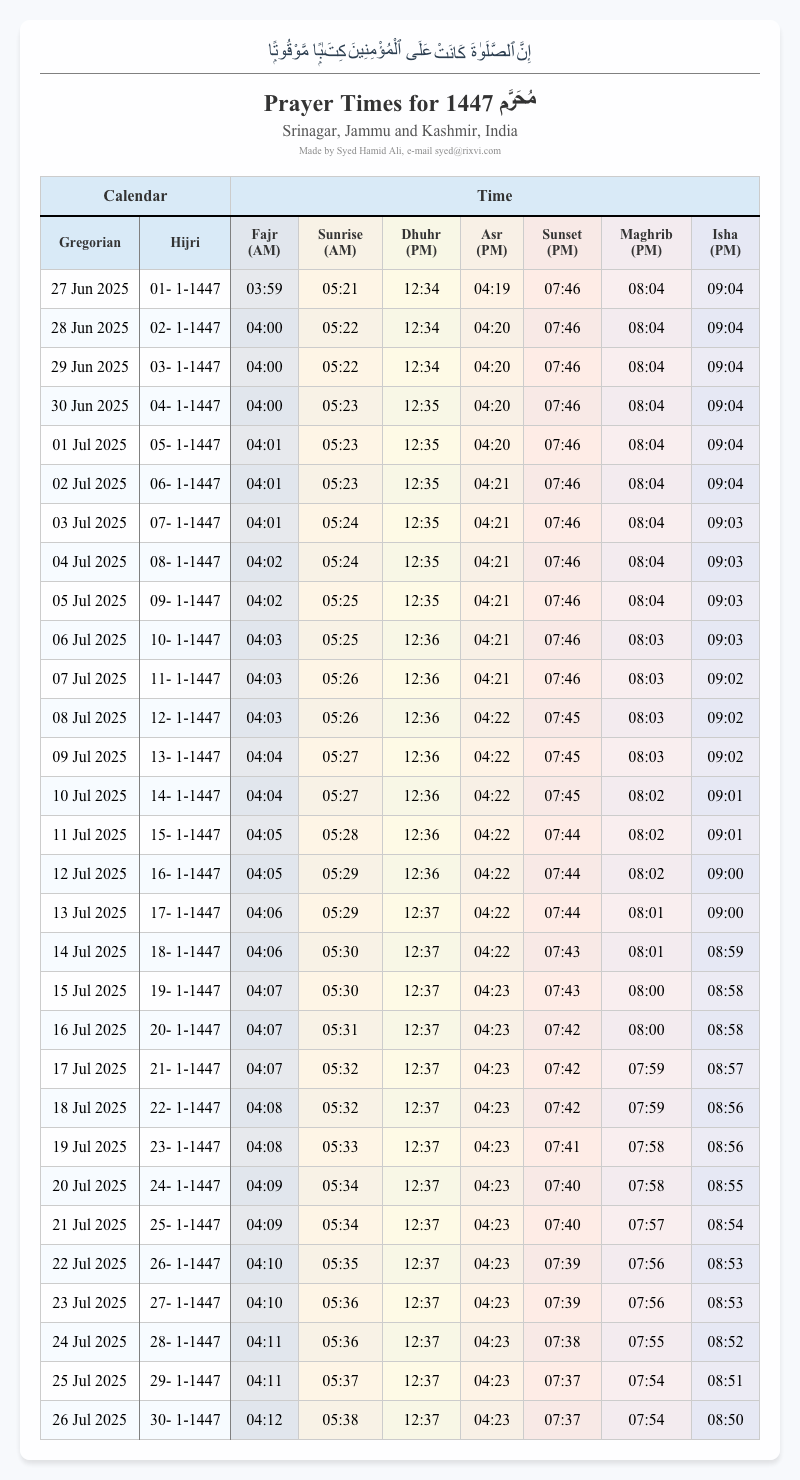

## إِنَّ ٱلصَّلَوٰةَ كَانَتْ عَلَى ٱلْمُؤْمِنِينَ كِتَـٰبًۭا مَّوْقُوتًۭا

In [15]:
!open $output_directory